<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:32] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


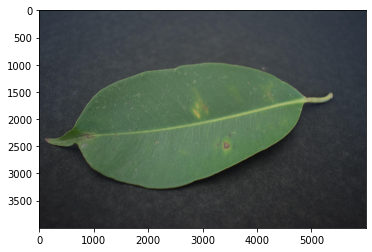

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

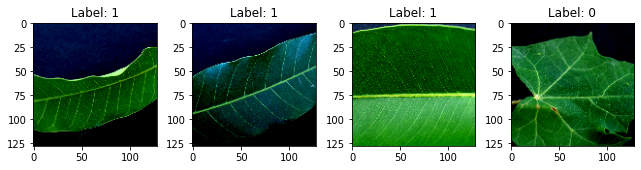

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:38] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:14:41] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.1554173721931111 samples/sec                   batch loss = 1.6012660264968872 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.1516991410935131 samples/sec                   batch loss = 0.9109418392181396 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.1659099734784435 samples/sec                   batch loss = 1.8150122165679932 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.1618860303996499 samples/sec                   batch loss = 0.5768834948539734 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.1723057665563086 samples/sec                   batch loss = 0.575320839881897 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.1528377053953167 samples/sec                   batch loss = 0.4931758642196655 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.120195488522 samples/sec                   batch loss = 0.6615555286407471 | accuracy = 0.6285714285714286


Epoch[1] Batch[40] Speed: 1.1697884562742373 samples/sec                   batch loss = 0.703231930732727 | accuracy = 0.61875


Epoch[1] Batch[45] Speed: 1.1723188730566971 samples/sec                   batch loss = 0.31060558557510376 | accuracy = 0.6333333333333333


Epoch[1] Batch[50] Speed: 1.1761295258268816 samples/sec                   batch loss = 0.3738061785697937 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.1555441436010803 samples/sec                   batch loss = 0.4031601846218109 | accuracy = 0.65


Epoch[1] Batch[60] Speed: 1.1533677499100286 samples/sec                   batch loss = 0.26408910751342773 | accuracy = 0.6458333333333334


Epoch[1] Batch[65] Speed: 1.1720094740345997 samples/sec                   batch loss = 0.714596688747406 | accuracy = 0.6384615384615384


Epoch[1] Batch[70] Speed: 1.1719652641149023 samples/sec                   batch loss = 0.7226202487945557 | accuracy = 0.625


Epoch[1] Batch[75] Speed: 1.1695302023434777 samples/sec                   batch loss = 1.231372356414795 | accuracy = 0.6333333333333333


Epoch[1] Batch[80] Speed: 1.1472465138911663 samples/sec                   batch loss = 0.6276805400848389 | accuracy = 0.6375


Epoch[1] Batch[85] Speed: 1.160052314733346 samples/sec                   batch loss = 0.516338586807251 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.1709241031522208 samples/sec                   batch loss = 1.3936693668365479 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.1732171203439397 samples/sec                   batch loss = 0.8938155174255371 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.1657569404794836 samples/sec                   batch loss = 0.3376215696334839 | accuracy = 0.6325


Epoch[1] Batch[105] Speed: 1.1417824098492149 samples/sec                   batch loss = 0.38283565640449524 | accuracy = 0.6309523809523809


Epoch[1] Batch[110] Speed: 1.1589517386435486 samples/sec                   batch loss = 0.5938149690628052 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.172705236850975 samples/sec                   batch loss = 0.6491640210151672 | accuracy = 0.6304347826086957


Epoch[1] Batch[120] Speed: 1.175720633817178 samples/sec                   batch loss = 0.5115032196044922 | accuracy = 0.6354166666666666


Epoch[1] Batch[125] Speed: 1.1662963397313473 samples/sec                   batch loss = 0.655449390411377 | accuracy = 0.638


Epoch[1] Batch[130] Speed: 1.1500324365704646 samples/sec                   batch loss = 0.27536725997924805 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.1704453278889524 samples/sec                   batch loss = 0.8391120433807373 | accuracy = 0.6481481481481481


Epoch[1] Batch[140] Speed: 1.1745279756262506 samples/sec                   batch loss = 0.5486350655555725 | accuracy = 0.6535714285714286


Epoch[1] Batch[145] Speed: 1.1762172591202635 samples/sec                   batch loss = 0.3224378824234009 | accuracy = 0.653448275862069


Epoch[1] Batch[150] Speed: 1.166645237534799 samples/sec                   batch loss = 0.418872207403183 | accuracy = 0.6566666666666666


Epoch[1] Batch[155] Speed: 1.1506373929225566 samples/sec                   batch loss = 0.782231867313385 | accuracy = 0.6580645161290323


Epoch[1] Batch[160] Speed: 1.1727231067025188 samples/sec                   batch loss = 0.6307145357131958 | accuracy = 0.653125


Epoch[1] Batch[165] Speed: 1.1691984804030238 samples/sec                   batch loss = 0.8742696642875671 | accuracy = 0.6530303030303031


Epoch[1] Batch[170] Speed: 1.1688492754927713 samples/sec                   batch loss = 0.5952000021934509 | accuracy = 0.6558823529411765


Epoch[1] Batch[175] Speed: 1.1446559915355086 samples/sec                   batch loss = 1.2608444690704346 | accuracy = 0.6585714285714286


Epoch[1] Batch[180] Speed: 1.1433382306951116 samples/sec                   batch loss = 1.0057663917541504 | accuracy = 0.6527777777777778


Epoch[1] Batch[185] Speed: 1.1687631263847404 samples/sec                   batch loss = 0.7911364436149597 | accuracy = 0.6554054054054054


Epoch[1] Batch[190] Speed: 1.1627286270539634 samples/sec                   batch loss = 0.6650141477584839 | accuracy = 0.656578947368421


Epoch[1] Batch[195] Speed: 1.172291431657065 samples/sec                   batch loss = 0.3397930860519409 | accuracy = 0.6615384615384615


Epoch[1] Batch[200] Speed: 1.1388244187094694 samples/sec                   batch loss = 0.41876673698425293 | accuracy = 0.665


Epoch[1] Batch[205] Speed: 1.154872643493333 samples/sec                   batch loss = 0.233256533741951 | accuracy = 0.6682926829268293


Epoch[1] Batch[210] Speed: 1.1652653033300655 samples/sec                   batch loss = 0.9100115299224854 | accuracy = 0.669047619047619


Epoch[1] Batch[215] Speed: 1.1590729608278176 samples/sec                   batch loss = 0.32070210576057434 | accuracy = 0.6732558139534883


Epoch[1] Batch[220] Speed: 1.182495791681559 samples/sec                   batch loss = 0.35837048292160034 | accuracy = 0.678409090909091


Epoch[1] Batch[225] Speed: 1.1675456956344916 samples/sec                   batch loss = 0.56685870885849 | accuracy = 0.68


Epoch[1] Batch[230] Speed: 1.1570775481637587 samples/sec                   batch loss = 0.33835530281066895 | accuracy = 0.6804347826086956


Epoch[1] Batch[235] Speed: 1.1487791990173912 samples/sec                   batch loss = 0.23579801619052887 | accuracy = 0.6829787234042554


Epoch[1] Batch[240] Speed: 1.152031448124095 samples/sec                   batch loss = 0.6713704466819763 | accuracy = 0.68125


Epoch[1] Batch[245] Speed: 1.187749509494157 samples/sec                   batch loss = 0.6538055539131165 | accuracy = 0.6785714285714286


Epoch[1] Batch[250] Speed: 1.1618294662391329 samples/sec                   batch loss = 0.5649576783180237 | accuracy = 0.679


Epoch[1] Batch[255] Speed: 1.1538416993860516 samples/sec                   batch loss = 0.9319067001342773 | accuracy = 0.6764705882352942


Epoch[1] Batch[260] Speed: 1.1406911600598832 samples/sec                   batch loss = 1.0714176893234253 | accuracy = 0.676923076923077


Epoch[1] Batch[265] Speed: 1.1655891283482813 samples/sec                   batch loss = 0.6407244205474854 | accuracy = 0.6764150943396227


Epoch[1] Batch[270] Speed: 1.1856104069488016 samples/sec                   batch loss = 0.5878599882125854 | accuracy = 0.6787037037037037


Epoch[1] Batch[275] Speed: 1.1645047798429227 samples/sec                   batch loss = 0.5436879396438599 | accuracy = 0.6790909090909091


Epoch[1] Batch[280] Speed: 1.1497341363985023 samples/sec                   batch loss = 0.42856043577194214 | accuracy = 0.6794642857142857


Epoch[1] Batch[285] Speed: 1.1411673208495121 samples/sec                   batch loss = 1.0871893167495728 | accuracy = 0.6771929824561403


Epoch[1] Batch[290] Speed: 1.1496342384721991 samples/sec                   batch loss = 1.219285488128662 | accuracy = 0.6801724137931034


Epoch[1] Batch[295] Speed: 1.1683086517932126 samples/sec                   batch loss = 0.4031793475151062 | accuracy = 0.6813559322033899


Epoch[1] Batch[300] Speed: 1.165267974150373 samples/sec                   batch loss = 1.0826504230499268 | accuracy = 0.6816666666666666


Epoch[1] Batch[305] Speed: 1.15522762518087 samples/sec                   batch loss = 0.3834492266178131 | accuracy = 0.6852459016393443


Epoch[1] Batch[310] Speed: 1.1552623080297169 samples/sec                   batch loss = 0.46227890253067017 | accuracy = 0.6846774193548387


Epoch[1] Batch[315] Speed: 1.163607551720639 samples/sec                   batch loss = 0.686999499797821 | accuracy = 0.6833333333333333


Epoch[1] Batch[320] Speed: 1.1855064393998278 samples/sec                   batch loss = 0.2936145067214966 | accuracy = 0.68203125


Epoch[1] Batch[325] Speed: 1.141581889465513 samples/sec                   batch loss = 0.4304823577404022 | accuracy = 0.6823076923076923


Epoch[1] Batch[330] Speed: 1.1484765955640774 samples/sec                   batch loss = 0.5495688915252686 | accuracy = 0.6833333333333333


Epoch[1] Batch[335] Speed: 1.1596325608078686 samples/sec                   batch loss = 0.7598235607147217 | accuracy = 0.685820895522388


Epoch[1] Batch[340] Speed: 1.1784122046447962 samples/sec                   batch loss = 0.21349595487117767 | accuracy = 0.6867647058823529


Epoch[1] Batch[345] Speed: 1.1818521357667653 samples/sec                   batch loss = 0.23427966237068176 | accuracy = 0.6876811594202898


Epoch[1] Batch[350] Speed: 1.1666913998072066 samples/sec                   batch loss = 0.6795598268508911 | accuracy = 0.6885714285714286


Epoch[1] Batch[355] Speed: 1.1486802534225637 samples/sec                   batch loss = 0.24454286694526672 | accuracy = 0.6915492957746479


Epoch[1] Batch[360] Speed: 1.1574089743054652 samples/sec                   batch loss = 0.3238944411277771 | accuracy = 0.6923611111111111


Epoch[1] Batch[365] Speed: 1.1752725063678746 samples/sec                   batch loss = 0.3844994604587555 | accuracy = 0.6910958904109589


Epoch[1] Batch[370] Speed: 1.1804751349486573 samples/sec                   batch loss = 0.504249632358551 | accuracy = 0.6905405405405406


Epoch[1] Batch[375] Speed: 1.1571306976676499 samples/sec                   batch loss = 0.7486537098884583 | accuracy = 0.6906666666666667


Epoch[1] Batch[380] Speed: 1.1366240876790166 samples/sec                   batch loss = 0.8576078414916992 | accuracy = 0.6901315789473684


Epoch[1] Batch[385] Speed: 1.1523530241648279 samples/sec                   batch loss = 0.5495204925537109 | accuracy = 0.6896103896103896


Epoch[1] Batch[390] Speed: 1.1806684480500607 samples/sec                   batch loss = 0.3025387227535248 | accuracy = 0.6891025641025641


Epoch[1] Batch[395] Speed: 1.1704681100556547 samples/sec                   batch loss = 0.4917171001434326 | accuracy = 0.6892405063291139


Epoch[1] Batch[400] Speed: 1.1449948732844066 samples/sec                   batch loss = 0.6028622984886169 | accuracy = 0.689375


Epoch[1] Batch[405] Speed: 1.1379050296626732 samples/sec                   batch loss = 0.34902623295783997 | accuracy = 0.6901234567901234


Epoch[1] Batch[410] Speed: 1.1560878331539424 samples/sec                   batch loss = 0.8273874521255493 | accuracy = 0.6896341463414634


Epoch[1] Batch[415] Speed: 1.1819130810175946 samples/sec                   batch loss = 0.6985556483268738 | accuracy = 0.6897590361445783


Epoch[1] Batch[420] Speed: 1.1691790067576937 samples/sec                   batch loss = 0.8360127806663513 | accuracy = 0.6892857142857143


Epoch[1] Batch[425] Speed: 1.1408709635587644 samples/sec                   batch loss = 0.49286866188049316 | accuracy = 0.69


Epoch[1] Batch[430] Speed: 1.134007902872801 samples/sec                   batch loss = 0.3653532564640045 | accuracy = 0.688953488372093


Epoch[1] Batch[435] Speed: 1.1512440920330158 samples/sec                   batch loss = 0.732381284236908 | accuracy = 0.6890804597701149


Epoch[1] Batch[440] Speed: 1.1763346146149682 samples/sec                   batch loss = 0.6476358771324158 | accuracy = 0.6880681818181819


Epoch[1] Batch[445] Speed: 1.154041152177321 samples/sec                   batch loss = 0.4570368528366089 | accuracy = 0.6887640449438203


Epoch[1] Batch[450] Speed: 1.1280074657171364 samples/sec                   batch loss = 0.438960462808609 | accuracy = 0.69


Epoch[1] Batch[455] Speed: 1.135092233429115 samples/sec                   batch loss = 0.6983598470687866 | accuracy = 0.6901098901098901


Epoch[1] Batch[460] Speed: 1.1587206540523345 samples/sec                   batch loss = 0.38589128851890564 | accuracy = 0.6907608695652174


Epoch[1] Batch[465] Speed: 1.1793021604281564 samples/sec                   batch loss = 0.5165916681289673 | accuracy = 0.693010752688172


Epoch[1] Batch[470] Speed: 1.1580516130822462 samples/sec                   batch loss = 0.5038047432899475 | accuracy = 0.6930851063829787


Epoch[1] Batch[475] Speed: 1.1431884168574 samples/sec                   batch loss = 0.6326950788497925 | accuracy = 0.6947368421052632


Epoch[1] Batch[480] Speed: 1.1586237492228233 samples/sec                   batch loss = 0.15445096790790558 | accuracy = 0.6958333333333333


Epoch[1] Batch[485] Speed: 1.1721916704686541 samples/sec                   batch loss = 0.46105340123176575 | accuracy = 0.695360824742268


Epoch[1] Batch[490] Speed: 1.1826415799780943 samples/sec                   batch loss = 0.2400939017534256 | accuracy = 0.6969387755102041


Epoch[1] Batch[495] Speed: 1.1585615818274253 samples/sec                   batch loss = 0.2962065637111664 | accuracy = 0.697979797979798


Epoch[1] Batch[500] Speed: 1.1376831868769592 samples/sec                   batch loss = 0.30829277634620667 | accuracy = 0.6985


Epoch[1] Batch[505] Speed: 1.1552378070856886 samples/sec                   batch loss = 1.126077651977539 | accuracy = 0.699009900990099


Epoch[1] Batch[510] Speed: 1.1742460918517805 samples/sec                   batch loss = 0.9059100151062012 | accuracy = 0.6995098039215686


Epoch[1] Batch[515] Speed: 1.1769389164851334 samples/sec                   batch loss = 0.2677028179168701 | accuracy = 0.7004854368932039


Epoch[1] Batch[520] Speed: 1.1508032162810664 samples/sec                   batch loss = 0.28004732728004456 | accuracy = 0.7019230769230769


Epoch[1] Batch[525] Speed: 1.1398935877479832 samples/sec                   batch loss = 0.6192208528518677 | accuracy = 0.7014285714285714


Epoch[1] Batch[530] Speed: 1.1551466536086352 samples/sec                   batch loss = 0.33125561475753784 | accuracy = 0.7028301886792453


Epoch[1] Batch[535] Speed: 1.1781667590466165 samples/sec                   batch loss = 0.3710506856441498 | accuracy = 0.7032710280373832


Epoch[1] Batch[540] Speed: 1.16780754456468 samples/sec                   batch loss = 0.6674113869667053 | accuracy = 0.7046296296296296


Epoch[1] Batch[545] Speed: 1.1409421094093428 samples/sec                   batch loss = 0.44041070342063904 | accuracy = 0.7041284403669725


Epoch[1] Batch[550] Speed: 1.1375767330616346 samples/sec                   batch loss = 0.7078625559806824 | accuracy = 0.7036363636363636


Epoch[1] Batch[555] Speed: 1.156788742839803 samples/sec                   batch loss = 0.7284289598464966 | accuracy = 0.704954954954955


Epoch[1] Batch[560] Speed: 1.1851364595328826 samples/sec                   batch loss = 1.4320186376571655 | accuracy = 0.7053571428571429


Epoch[1] Batch[565] Speed: 1.162702922035733 samples/sec                   batch loss = 0.6698516607284546 | accuracy = 0.7048672566371681


Epoch[1] Batch[570] Speed: 1.143071039482216 samples/sec                   batch loss = 0.2882750630378723 | accuracy = 0.7048245614035088


Epoch[1] Batch[575] Speed: 1.1450848223441892 samples/sec                   batch loss = 0.6840139031410217 | accuracy = 0.7047826086956521


Epoch[1] Batch[580] Speed: 1.1595081763729045 samples/sec                   batch loss = 0.6046804785728455 | accuracy = 0.7047413793103449


Epoch[1] Batch[585] Speed: 1.1874151888809488 samples/sec                   batch loss = 0.544401228427887 | accuracy = 0.7047008547008548


Epoch[1] Batch[590] Speed: 1.1555765372424291 samples/sec                   batch loss = 0.36406123638153076 | accuracy = 0.7050847457627119


Epoch[1] Batch[595] Speed: 1.130772488228882 samples/sec                   batch loss = 0.33010420203208923 | accuracy = 0.7058823529411765


Epoch[1] Batch[600] Speed: 1.1519072652781432 samples/sec                   batch loss = 0.6930221915245056 | accuracy = 0.70625


Epoch[1] Batch[605] Speed: 1.1742234089274686 samples/sec                   batch loss = 0.565689206123352 | accuracy = 0.7074380165289256


Epoch[1] Batch[610] Speed: 1.1814717031064694 samples/sec                   batch loss = 0.34290412068367004 | accuracy = 0.7077868852459016


Epoch[1] Batch[615] Speed: 1.1595105804582997 samples/sec                   batch loss = 0.6243912577629089 | accuracy = 0.7060975609756097


Epoch[1] Batch[620] Speed: 1.1309991156788826 samples/sec                   batch loss = 1.1008714437484741 | accuracy = 0.7056451612903226


Epoch[1] Batch[625] Speed: 1.1534368152051224 samples/sec                   batch loss = 0.33064669370651245 | accuracy = 0.7056


Epoch[1] Batch[630] Speed: 1.1675372456079258 samples/sec                   batch loss = 0.22784122824668884 | accuracy = 0.7063492063492064


Epoch[1] Batch[635] Speed: 1.1747508491749121 samples/sec                   batch loss = 0.2597643733024597 | accuracy = 0.7074803149606299


Epoch[1] Batch[640] Speed: 1.1436245676869177 samples/sec                   batch loss = 0.7588420510292053 | accuracy = 0.708203125


Epoch[1] Batch[645] Speed: 1.1362641305666286 samples/sec                   batch loss = 0.7649877071380615 | accuracy = 0.7085271317829457


Epoch[1] Batch[650] Speed: 1.1509145286322404 samples/sec                   batch loss = 0.4077615439891815 | accuracy = 0.7092307692307692


Epoch[1] Batch[655] Speed: 1.1701687463857722 samples/sec                   batch loss = 0.4481285810470581 | accuracy = 0.7095419847328245


Epoch[1] Batch[660] Speed: 1.1761617646419633 samples/sec                   batch loss = 0.39551231265068054 | accuracy = 0.7106060606060606


Epoch[1] Batch[665] Speed: 1.1456936588307929 samples/sec                   batch loss = 0.7103946208953857 | accuracy = 0.7097744360902256


Epoch[1] Batch[670] Speed: 1.1408134016547804 samples/sec                   batch loss = 0.45003023743629456 | accuracy = 0.7104477611940299


Epoch[1] Batch[675] Speed: 1.155876364089822 samples/sec                   batch loss = 0.4618159830570221 | accuracy = 0.71


Epoch[1] Batch[680] Speed: 1.1833640497120768 samples/sec                   batch loss = 0.2944613993167877 | accuracy = 0.7106617647058824


Epoch[1] Batch[685] Speed: 1.1721581748299232 samples/sec                   batch loss = 0.814380943775177 | accuracy = 0.7102189781021898


Epoch[1] Batch[690] Speed: 1.1416230599309347 samples/sec                   batch loss = 0.6329498291015625 | accuracy = 0.7094202898550724


Epoch[1] Batch[695] Speed: 1.1362011845948625 samples/sec                   batch loss = 0.5248892307281494 | accuracy = 0.7097122302158273


Epoch[1] Batch[700] Speed: 1.151231768509945 samples/sec                   batch loss = 0.24647942185401917 | accuracy = 0.71


Epoch[1] Batch[705] Speed: 1.18400768278911 samples/sec                   batch loss = 0.29744380712509155 | accuracy = 0.7102836879432625


Epoch[1] Batch[710] Speed: 1.168607064364087 samples/sec                   batch loss = 0.548435628414154 | accuracy = 0.7109154929577465


Epoch[1] Batch[715] Speed: 1.1386975021192927 samples/sec                   batch loss = 0.432609498500824 | accuracy = 0.7104895104895105


Epoch[1] Batch[720] Speed: 1.1458345043433174 samples/sec                   batch loss = 0.6891158819198608 | accuracy = 0.7104166666666667


Epoch[1] Batch[725] Speed: 1.1550047023651717 samples/sec                   batch loss = 1.2261855602264404 | accuracy = 0.7106896551724138


Epoch[1] Batch[730] Speed: 1.182886725371462 samples/sec                   batch loss = 0.36971816420555115 | accuracy = 0.7113013698630137


Epoch[1] Batch[735] Speed: 1.167783402737953 samples/sec                   batch loss = 0.19510018825531006 | accuracy = 0.7119047619047619


Epoch[1] Batch[740] Speed: 1.1484345362409019 samples/sec                   batch loss = 0.8649803400039673 | accuracy = 0.7121621621621622


Epoch[1] Batch[745] Speed: 1.155397797920173 samples/sec                   batch loss = 1.054635763168335 | accuracy = 0.7120805369127516


Epoch[1] Batch[750] Speed: 1.1716860818447494 samples/sec                   batch loss = 0.9855386018753052 | accuracy = 0.712


Epoch[1] Batch[755] Speed: 1.1849872098321383 samples/sec                   batch loss = 1.0155539512634277 | accuracy = 0.7125827814569536


Epoch[1] Batch[760] Speed: 1.1653668031094477 samples/sec                   batch loss = 0.3561631441116333 | accuracy = 0.7131578947368421


Epoch[1] Batch[765] Speed: 1.1422406623862071 samples/sec                   batch loss = 0.5384782552719116 | accuracy = 0.7130718954248366


Epoch[1] Batch[770] Speed: 1.1657472203119927 samples/sec                   batch loss = 0.5389049053192139 | accuracy = 0.712987012987013


Epoch[1] Batch[775] Speed: 1.1716899277796584 samples/sec                   batch loss = 0.08942293375730515 | accuracy = 0.714516129032258


Epoch[1] Batch[780] Speed: 1.1921929245607483 samples/sec                   batch loss = 0.31585806608200073 | accuracy = 0.7153846153846154


Epoch[1] Batch[785] Speed: 1.1693000146012518 samples/sec                   batch loss = 0.6303460597991943 | accuracy = 0.7156050955414013


[Epoch 1] training: accuracy=0.7157360406091371
[Epoch 1] time cost: 707.626588344574
[Epoch 1] validation: validation accuracy=0.7477777777777778


Epoch[2] Batch[5] Speed: 1.1798022314901526 samples/sec                   batch loss = 0.3156973421573639 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.153097990829769 samples/sec                   batch loss = 0.4403045177459717 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.1815182973115856 samples/sec                   batch loss = 0.7639739513397217 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2001598666471234 samples/sec                   batch loss = 1.0883687734603882 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.1791663934384173 samples/sec                   batch loss = 1.0703709125518799 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.1715665431382956 samples/sec                   batch loss = 0.37574759125709534 | accuracy = 0.7


Epoch[2] Batch[35] Speed: 1.1528304175099884 samples/sec                   batch loss = 0.4957543611526489 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.1826550853443452 samples/sec                   batch loss = 0.260104775428772 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2027209230171023 samples/sec                   batch loss = 0.3322281837463379 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.1886696310403364 samples/sec                   batch loss = 0.6185050010681152 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.1813495771679197 samples/sec                   batch loss = 0.40111494064331055 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.1634821517672433 samples/sec                   batch loss = 0.725415825843811 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.1953354801169116 samples/sec                   batch loss = 0.4597285985946655 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.19711098746364 samples/sec                   batch loss = 0.5400148034095764 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.1776253364826117 samples/sec                   batch loss = 0.7269103527069092 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.172270708108212 samples/sec                   batch loss = 0.610448956489563 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.1469957636837664 samples/sec                   batch loss = 0.16838930547237396 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.171000844893767 samples/sec                   batch loss = 0.13233515620231628 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.1840600761071864 samples/sec                   batch loss = 1.2324944734573364 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.1692251253118335 samples/sec                   batch loss = 0.2156086564064026 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.1520961603698308 samples/sec                   batch loss = 0.43263885378837585 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.1687138691328995 samples/sec                   batch loss = 0.9988061189651489 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.1850671454058737 samples/sec                   batch loss = 0.3825645446777344 | accuracy = 0.7478260869565218


Epoch[2] Batch[120] Speed: 1.2038646881261377 samples/sec                   batch loss = 0.15420763194561005 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.1791188243682358 samples/sec                   batch loss = 0.3778148889541626 | accuracy = 0.742


Epoch[2] Batch[130] Speed: 1.1546549434830626 samples/sec                   batch loss = 0.39460456371307373 | accuracy = 0.7442307692307693


Epoch[2] Batch[135] Speed: 1.1768515708139238 samples/sec                   batch loss = 0.13486412167549133 | accuracy = 0.7444444444444445


Epoch[2] Batch[140] Speed: 1.1802284972304697 samples/sec                   batch loss = 0.24324041604995728 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.1968308822763591 samples/sec                   batch loss = 2.824523687362671 | accuracy = 0.7362068965517241


Epoch[2] Batch[150] Speed: 1.1699339832960376 samples/sec                   batch loss = 0.4910823106765747 | accuracy = 0.7383333333333333


Epoch[2] Batch[155] Speed: 1.1421487491906452 samples/sec                   batch loss = 0.40084171295166016 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.1588911370594757 samples/sec                   batch loss = 0.4633471369743347 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.1760188059647927 samples/sec                   batch loss = 0.32406085729599 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.1988367781553129 samples/sec                   batch loss = 0.5140259265899658 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.173672713016896 samples/sec                   batch loss = 0.31071487069129944 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.1509094756902059 samples/sec                   batch loss = 1.2630406618118286 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.1628276704925518 samples/sec                   batch loss = 0.28948357701301575 | accuracy = 0.7445945945945946


Epoch[2] Batch[190] Speed: 1.1944604574745301 samples/sec                   batch loss = 0.3924603760242462 | accuracy = 0.7447368421052631


Epoch[2] Batch[195] Speed: 1.1966149150633312 samples/sec                   batch loss = 0.46523210406303406 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.1654026641163406 samples/sec                   batch loss = 0.48489490151405334 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.1614754016079896 samples/sec                   batch loss = 0.25664159655570984 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.178367510374059 samples/sec                   batch loss = 0.32840684056282043 | accuracy = 0.7416666666666667


Epoch[2] Batch[215] Speed: 1.1916203398883327 samples/sec                   batch loss = 0.7162884473800659 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.186832070694298 samples/sec                   batch loss = 0.5226855278015137 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.1682078590821194 samples/sec                   batch loss = 0.32374098896980286 | accuracy = 0.7422222222222222


Epoch[2] Batch[230] Speed: 1.1503058106596467 samples/sec                   batch loss = 0.5540618300437927 | accuracy = 0.7391304347826086


Epoch[2] Batch[235] Speed: 1.1680979749840734 samples/sec                   batch loss = 0.4731593728065491 | accuracy = 0.7425531914893617


Epoch[2] Batch[240] Speed: 1.1899917991845714 samples/sec                   batch loss = 0.8475962281227112 | accuracy = 0.7427083333333333


Epoch[2] Batch[245] Speed: 1.1855042613867217 samples/sec                   batch loss = 0.47094520926475525 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.1708376479369949 samples/sec                   batch loss = 0.5256435871124268 | accuracy = 0.743


Epoch[2] Batch[255] Speed: 1.1518054078754274 samples/sec                   batch loss = 0.5177167654037476 | accuracy = 0.7401960784313726


Epoch[2] Batch[260] Speed: 1.1729016711798483 samples/sec                   batch loss = 0.39659398794174194 | accuracy = 0.7423076923076923


Epoch[2] Batch[265] Speed: 1.1887376826906944 samples/sec                   batch loss = 0.4206448197364807 | accuracy = 0.7405660377358491


Epoch[2] Batch[270] Speed: 1.1916359977825357 samples/sec                   batch loss = 0.3609926700592041 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.1622887364607783 samples/sec                   batch loss = 0.7933268547058105 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.1354555211313018 samples/sec                   batch loss = 0.767443060874939 | accuracy = 0.7446428571428572


Epoch[2] Batch[285] Speed: 1.1681143220864063 samples/sec                   batch loss = 0.24725186824798584 | accuracy = 0.7456140350877193


Epoch[2] Batch[290] Speed: 1.193441781462617 samples/sec                   batch loss = 0.5730743408203125 | accuracy = 0.743103448275862


Epoch[2] Batch[295] Speed: 1.1865729509831517 samples/sec                   batch loss = 0.39036253094673157 | accuracy = 0.7423728813559322


Epoch[2] Batch[300] Speed: 1.1624986115952771 samples/sec                   batch loss = 0.6178735494613647 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.1404286928899126 samples/sec                   batch loss = 0.6401460766792297 | accuracy = 0.7434426229508196


Epoch[2] Batch[310] Speed: 1.1721584205122357 samples/sec                   batch loss = 0.4135955572128296 | accuracy = 0.7443548387096774


Epoch[2] Batch[315] Speed: 1.189131069446501 samples/sec                   batch loss = 0.9534185528755188 | accuracy = 0.7444444444444445


Epoch[2] Batch[320] Speed: 1.17232944038603 samples/sec                   batch loss = 0.43568655848503113 | accuracy = 0.74453125


Epoch[2] Batch[325] Speed: 1.146496785688635 samples/sec                   batch loss = 0.31022757291793823 | accuracy = 0.7461538461538462


Epoch[2] Batch[330] Speed: 1.1489306392305627 samples/sec                   batch loss = 0.345170795917511 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.1714777844530972 samples/sec                   batch loss = 0.9185965061187744 | accuracy = 0.7455223880597015


Epoch[2] Batch[340] Speed: 1.1972435707413622 samples/sec                   batch loss = 0.8875975012779236 | accuracy = 0.7470588235294118


Epoch[2] Batch[345] Speed: 1.1748751523021814 samples/sec                   batch loss = 0.43083205819129944 | accuracy = 0.7478260869565218


Epoch[2] Batch[350] Speed: 1.1539016152832737 samples/sec                   batch loss = 0.0885421559214592 | accuracy = 0.7485714285714286


Epoch[2] Batch[355] Speed: 1.1591072343126145 samples/sec                   batch loss = 0.4202410578727722 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.1760024841742538 samples/sec                   batch loss = 0.5285118818283081 | accuracy = 0.7506944444444444


Epoch[2] Batch[365] Speed: 1.191654703157713 samples/sec                   batch loss = 0.4538416862487793 | accuracy = 0.7513698630136987


Epoch[2] Batch[370] Speed: 1.1751053182549354 samples/sec                   batch loss = 0.5871593356132507 | accuracy = 0.7533783783783784


Epoch[2] Batch[375] Speed: 1.1346198233932914 samples/sec                   batch loss = 0.3467543125152588 | accuracy = 0.7526666666666667


Epoch[2] Batch[380] Speed: 1.1602242329043573 samples/sec                   batch loss = 0.33800286054611206 | accuracy = 0.7513157894736842


Epoch[2] Batch[385] Speed: 1.1785726353386419 samples/sec                   batch loss = 0.8039259314537048 | accuracy = 0.7506493506493507


Epoch[2] Batch[390] Speed: 1.2034239434311236 samples/sec                   batch loss = 1.7084561586380005 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.1706392904664984 samples/sec                   batch loss = 0.8765993714332581 | accuracy = 0.7481012658227848


Epoch[2] Batch[400] Speed: 1.145403626179533 samples/sec                   batch loss = 0.36371874809265137 | accuracy = 0.748125


Epoch[2] Batch[405] Speed: 1.1637087628978604 samples/sec                   batch loss = 0.9058958888053894 | accuracy = 0.7487654320987654


Epoch[2] Batch[410] Speed: 1.1776359170329431 samples/sec                   batch loss = 0.28470665216445923 | accuracy = 0.749390243902439


Epoch[2] Batch[415] Speed: 1.1982840695908603 samples/sec                   batch loss = 0.32286497950553894 | accuracy = 0.75


Epoch[2] Batch[420] Speed: 1.170600002749064 samples/sec                   batch loss = 0.41632646322250366 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.1531079767212236 samples/sec                   batch loss = 0.8229799866676331 | accuracy = 0.7505882352941177


Epoch[2] Batch[430] Speed: 1.1636671140615606 samples/sec                   batch loss = 1.4842246770858765 | accuracy = 0.7459302325581395


Epoch[2] Batch[435] Speed: 1.187521845038499 samples/sec                   batch loss = 0.547718346118927 | accuracy = 0.746551724137931


Epoch[2] Batch[440] Speed: 1.2017933043847449 samples/sec                   batch loss = 0.6652002334594727 | accuracy = 0.7443181818181818


Epoch[2] Batch[445] Speed: 1.1776712971288832 samples/sec                   batch loss = 0.21203410625457764 | accuracy = 0.7460674157303371


Epoch[2] Batch[450] Speed: 1.1560921350225462 samples/sec                   batch loss = 0.32199129462242126 | accuracy = 0.745


Epoch[2] Batch[455] Speed: 1.1652367344120946 samples/sec                   batch loss = 0.23641663789749146 | accuracy = 0.7450549450549451


Epoch[2] Batch[460] Speed: 1.1977745397119581 samples/sec                   batch loss = 0.8851907253265381 | accuracy = 0.7445652173913043


Epoch[2] Batch[465] Speed: 1.201688028699754 samples/sec                   batch loss = 1.0948853492736816 | accuracy = 0.7456989247311828


Epoch[2] Batch[470] Speed: 1.1740840432366961 samples/sec                   batch loss = 1.2620763778686523 | accuracy = 0.7446808510638298


Epoch[2] Batch[475] Speed: 1.1493742543755745 samples/sec                   batch loss = 0.3424369692802429 | accuracy = 0.7452631578947368


Epoch[2] Batch[480] Speed: 1.1729365213696887 samples/sec                   batch loss = 1.4373390674591064 | accuracy = 0.7458333333333333


Epoch[2] Batch[485] Speed: 1.1965503107731432 samples/sec                   batch loss = 0.6361592411994934 | accuracy = 0.7463917525773196


Epoch[2] Batch[490] Speed: 1.198683201618248 samples/sec                   batch loss = 1.0358085632324219 | accuracy = 0.7438775510204082


Epoch[2] Batch[495] Speed: 1.1785161733228875 samples/sec                   batch loss = 1.8990496397018433 | accuracy = 0.7439393939393939


Epoch[2] Batch[500] Speed: 1.1526088147435847 samples/sec                   batch loss = 0.5575858950614929 | accuracy = 0.7445


Epoch[2] Batch[505] Speed: 1.1709852342038032 samples/sec                   batch loss = 0.2791246175765991 | accuracy = 0.7435643564356436


Epoch[2] Batch[510] Speed: 1.1852202667866307 samples/sec                   batch loss = 0.16563424468040466 | accuracy = 0.7436274509803922


Epoch[2] Batch[515] Speed: 1.2007678459738937 samples/sec                   batch loss = 0.3942033648490906 | accuracy = 0.7441747572815534


Epoch[2] Batch[520] Speed: 1.1822449765805478 samples/sec                   batch loss = 0.33867743611335754 | accuracy = 0.7451923076923077


Epoch[2] Batch[525] Speed: 1.1715940324264171 samples/sec                   batch loss = 0.6216673851013184 | accuracy = 0.7438095238095238


Epoch[2] Batch[530] Speed: 1.1834858411712896 samples/sec                   batch loss = 0.6396927833557129 | accuracy = 0.7433962264150943


Epoch[2] Batch[535] Speed: 1.2076325251121995 samples/sec                   batch loss = 0.3743973970413208 | accuracy = 0.7448598130841122


Epoch[2] Batch[540] Speed: 1.1996831395668954 samples/sec                   batch loss = 0.5863887071609497 | accuracy = 0.7453703703703703


Epoch[2] Batch[545] Speed: 1.176417264088497 samples/sec                   batch loss = 0.5836904644966125 | accuracy = 0.744954128440367


Epoch[2] Batch[550] Speed: 1.1660275501998039 samples/sec                   batch loss = 0.27787113189697266 | accuracy = 0.7445454545454545


Epoch[2] Batch[555] Speed: 1.1825956473681507 samples/sec                   batch loss = 0.3531624376773834 | accuracy = 0.7432432432432432


Epoch[2] Batch[560] Speed: 1.2048502768204283 samples/sec                   batch loss = 0.2459469884634018 | accuracy = 0.7446428571428572


Epoch[2] Batch[565] Speed: 1.1953241533164278 samples/sec                   batch loss = 0.7078984975814819 | accuracy = 0.7442477876106195


Epoch[2] Batch[570] Speed: 1.175647308946633 samples/sec                   batch loss = 0.6667288541793823 | accuracy = 0.7429824561403509


Epoch[2] Batch[575] Speed: 1.155287923764236 samples/sec                   batch loss = 0.4359052777290344 | accuracy = 0.7430434782608696


Epoch[2] Batch[580] Speed: 1.188371491606247 samples/sec                   batch loss = 0.37994253635406494 | accuracy = 0.7435344827586207


Epoch[2] Batch[585] Speed: 1.2050964068304821 samples/sec                   batch loss = 0.1613135039806366 | accuracy = 0.7431623931623932


Epoch[2] Batch[590] Speed: 1.197098772827228 samples/sec                   batch loss = 0.39885956048965454 | accuracy = 0.7432203389830508


Epoch[2] Batch[595] Speed: 1.1773038776074451 samples/sec                   batch loss = 0.5277379751205444 | accuracy = 0.7432773109243698


Epoch[2] Batch[600] Speed: 1.1549754416844733 samples/sec                   batch loss = 0.7006052732467651 | accuracy = 0.74125


Epoch[2] Batch[605] Speed: 1.1807682446473573 samples/sec                   batch loss = 0.8126007914543152 | accuracy = 0.740909090909091


Epoch[2] Batch[610] Speed: 1.2002264068444002 samples/sec                   batch loss = 0.8639430403709412 | accuracy = 0.7413934426229508


Epoch[2] Batch[615] Speed: 1.1909657005300394 samples/sec                   batch loss = 0.8674737811088562 | accuracy = 0.7402439024390244


Epoch[2] Batch[620] Speed: 1.162371034560642 samples/sec                   batch loss = 0.3230997323989868 | accuracy = 0.7411290322580645


Epoch[2] Batch[625] Speed: 1.16988585095775 samples/sec                   batch loss = 0.4429727792739868 | accuracy = 0.7408


Epoch[2] Batch[630] Speed: 1.1822996302057915 samples/sec                   batch loss = 0.48973318934440613 | accuracy = 0.7408730158730159


Epoch[2] Batch[635] Speed: 1.203193337419706 samples/sec                   batch loss = 0.5785992741584778 | accuracy = 0.7421259842519685


Epoch[2] Batch[640] Speed: 1.1883073535070765 samples/sec                   batch loss = 0.6580880284309387 | accuracy = 0.7421875


Epoch[2] Batch[645] Speed: 1.1777330520625438 samples/sec                   batch loss = 0.4943130314350128 | accuracy = 0.7426356589147287


Epoch[2] Batch[650] Speed: 1.1616295645146504 samples/sec                   batch loss = 0.14460504055023193 | accuracy = 0.7426923076923077


Epoch[2] Batch[655] Speed: 1.1778766759269594 samples/sec                   batch loss = 0.25831761956214905 | accuracy = 0.7427480916030534


Epoch[2] Batch[660] Speed: 1.2058137341113249 samples/sec                   batch loss = 0.7555432915687561 | accuracy = 0.7431818181818182


Epoch[2] Batch[665] Speed: 1.1923395886115375 samples/sec                   batch loss = 0.12564429640769958 | accuracy = 0.7439849624060151


Epoch[2] Batch[670] Speed: 1.1841484115450336 samples/sec                   batch loss = 0.19627854228019714 | accuracy = 0.7444029850746269


Epoch[2] Batch[675] Speed: 1.1724133304411801 samples/sec                   batch loss = 1.046775460243225 | accuracy = 0.7451851851851852


Epoch[2] Batch[680] Speed: 1.1918687141225637 samples/sec                   batch loss = 0.31532612442970276 | accuracy = 0.7459558823529412


Epoch[2] Batch[685] Speed: 1.2123352968282777 samples/sec                   batch loss = 0.21190299093723297 | accuracy = 0.7463503649635036


Epoch[2] Batch[690] Speed: 1.195556608630743 samples/sec                   batch loss = 0.3497270345687866 | accuracy = 0.7460144927536232


Epoch[2] Batch[695] Speed: 1.178250079920804 samples/sec                   batch loss = 0.5013662576675415 | accuracy = 0.7453237410071942


Epoch[2] Batch[700] Speed: 1.1720543423261398 samples/sec                   batch loss = 0.49654948711395264 | accuracy = 0.7460714285714286


Epoch[2] Batch[705] Speed: 1.1839863758281606 samples/sec                   batch loss = 0.2534056603908539 | accuracy = 0.7450354609929078


Epoch[2] Batch[710] Speed: 1.2001482765285723 samples/sec                   batch loss = 0.3835311830043793 | accuracy = 0.745774647887324


Epoch[2] Batch[715] Speed: 1.1911523165793176 samples/sec                   batch loss = 0.24547824263572693 | accuracy = 0.7454545454545455


Epoch[2] Batch[720] Speed: 1.1804280416052433 samples/sec                   batch loss = 0.6717644929885864 | accuracy = 0.7447916666666666


Epoch[2] Batch[725] Speed: 1.1697206811023553 samples/sec                   batch loss = 0.4260537624359131 | accuracy = 0.7448275862068966


Epoch[2] Batch[730] Speed: 1.1835426968976794 samples/sec                   batch loss = 0.17273801565170288 | accuracy = 0.7452054794520548


Epoch[2] Batch[735] Speed: 1.2046177400134224 samples/sec                   batch loss = 0.32642239332199097 | accuracy = 0.7459183673469387


Epoch[2] Batch[740] Speed: 1.1898925472138773 samples/sec                   batch loss = 0.1379779577255249 | accuracy = 0.745945945945946


Epoch[2] Batch[745] Speed: 1.169971757718196 samples/sec                   batch loss = 0.4956146478652954 | accuracy = 0.7456375838926175


Epoch[2] Batch[750] Speed: 1.1693489137643287 samples/sec                   batch loss = 1.0061722993850708 | accuracy = 0.7456666666666667


Epoch[2] Batch[755] Speed: 1.1837942300423308 samples/sec                   batch loss = 0.5483848452568054 | accuracy = 0.7456953642384105


Epoch[2] Batch[760] Speed: 1.200719033717391 samples/sec                   batch loss = 0.477069228887558 | accuracy = 0.7463815789473685


Epoch[2] Batch[765] Speed: 1.1847453762370832 samples/sec                   batch loss = 0.46799176931381226 | accuracy = 0.7470588235294118


Epoch[2] Batch[770] Speed: 1.172066133104116 samples/sec                   batch loss = 0.8537896871566772 | accuracy = 0.7474025974025974


Epoch[2] Batch[775] Speed: 1.173903311551411 samples/sec                   batch loss = 0.22066578269004822 | accuracy = 0.7480645161290322


Epoch[2] Batch[780] Speed: 1.1915557660023979 samples/sec                   batch loss = 0.19986701011657715 | accuracy = 0.7483974358974359


Epoch[2] Batch[785] Speed: 1.2044120958833786 samples/sec                   batch loss = 0.4193160831928253 | accuracy = 0.7480891719745223


[Epoch 2] training: accuracy=0.7480964467005076
[Epoch 2] time cost: 687.6990053653717
[Epoch 2] validation: validation accuracy=0.7355555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.72

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)